<h1 align=center>Data Analysis and Predictions</h1>

In [55]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.display import clear_output
import json as JSON

#### Import Data

This file is continued from the [Data Collection File](https://github.com/gokulmuthiah/Coursera_Capstone/blob/master/3.Foursquare-Data-Collection.ipynb)

In [57]:
df=pd.read_json("mapping.json",orient="table")
df.head()

,code,name,lat,long,area,borough,population,medAge,popDensity,dayPop,...,Middle Eastern Restaurant,Nightclub/Lounge,Pizza Place,Seafood Restaurant,Steakhouse,culturalFactor,x,y,merc_x,merc_y
0,BK09,Brooklyn Heights-Cobble Hill,40.695469,-73.994871,1.615327,Brooklyn,24212,37.1,14988,21307,...,2,2,6,0,1,24.125417,"[-73.9923636704, -73.9943609283, -73.996232780...","[40.6896901238, 40.6902394801, 40.6907577746, ...","[-8236792.246379642, -8237014.580112053, -8237...","[4966678.212482733, 4966758.86422228, 4966834...."
1,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,40.588300,-73.941511,10.214922,Brooklyn,67681,43.9,6625,59559,...,8,3,10,6,0,16.608750,"[-73.9180925648, -73.9181253337, -73.918055685...","[40.586570335, 40.5865073745, 40.5864365457, 4...","[-8228524.424723598, -8228528.07254086, -82285...","[4951550.813154518, 4951541.584147879, 4951531..."
2,BK19,Brighton Beach,40.580922,-73.961217,2.770061,Brooklyn,35811,44.3,12927,31514,...,2,2,2,1,0,3.000000,"[-73.9603495359, -73.9603171203, -73.960317663...","[40.5873062856, 40.5865147236, 40.586436468, 4...","[-8233228.4492289135, -8233224.84074083, -8233...","[4951658.692436623, 4951542.66140845, 4951531...."
3,BK21,Seagate-Coney Island,40.576480,-73.991231,6.242851,Brooklyn,31132,39.0,4986,27396,...,1,3,10,2,0,38.950583,"[-73.9745900058, -73.9745935098, -73.974586671...","[40.5831388208, 40.5828996033, 40.5828446826, ...","[-8234813.69108684, -8234814.081150336, -82348...","[4951047.820487246, 4951012.756856543, 4951004..."
4,BK23,West Brighton,40.579088,-73.973391,1.409979,Brooklyn,16436,58.0,11656,14464,...,1,1,4,0,0,0.000000,"[-73.9688899588, -73.9689458946, -73.969037798...","[40.575261239, 40.5752786881, 40.5753086191, 4...","[-8234179.164757303, -8234185.391502076, -8234...","[4949893.2191320015, 4949895.776461337, 494990..."


#### Seperate Data into Features and Target Variables

In [58]:
features=df.loc[:,'population':'AADT'].join(df['culturalFactor'])
targets=df.loc[:,'American Restaurant':'Steakhouse']
features=features.astype(float)
targets['European Restaurant']=targets['European Restaurant']+targets['Italian Restaurant']
targets['Japanese Restaurant']=targets['Japanese Restaurant']+targets['Seafood Restaurant']

# targets with less than 500 counts are dropped to avoid sparse targets and whichever targets can be merged are combined
targets.drop(['Italian Restaurant','Indian Restaurant','Seafood Restaurant','Steakhouse','Middle Eastern Restaurant'],axis=1,inplace=True)
targets.head()

,American Restaurant,Asian Restaurant,Bakery/Dessert,Bar,Chinese Restaurant,Coffee Shop,Deli / Bodega,Diner,European Restaurant,Fast Food Restaurant,Japanese Restaurant,Latin American Restaurant,Nightclub/Lounge,Pizza Place
0,2,4,12,7,3,12,8,5,6,9,6,4,2,6
1,5,1,16,13,3,15,7,10,11,17,15,1,3,10
2,1,2,10,3,1,12,2,4,6,5,5,1,2,2
3,4,2,6,6,1,5,6,5,1,16,2,10,3,10
4,1,0,2,3,1,2,4,5,1,6,1,0,1,4


## Exploratory Data Analysis

### Supporting Plotting Functions

In [16]:
parameters={}
results={}
estimators={}
optResults={}
optEstimators={}

In [82]:
def heatMap(values,title="",size=''):
    if(size==''):
        plt.figure(figsize=(20,1))
    else:
        plt.figure(figsize=size)
    plt.title(title,fontsize=16,pad=24)
    plt.xticks(rotation=80)
    sns.heatmap(values,annot=True,cmap='RdBu_r')

def univariatePlots(f,t=None,f1='',cols=3):
    if(type(f)!=DataFrame):
        f=DataFrame(f)
    if(type(t)==DataFrame or type(t)==Series):
        f=f.join(t)       
    rows=int(np.ceil(len(f.columns)/cols))
    fig,axes=plt.subplots(rows,cols,figsize=(18,rows*5))
    index=0
    if(rows==1):
        for x in axes:
            if(index<len(f.columns)):
                data=f.iloc[:,index] 
                sns.distplot(data,ax=x)
                x.legend(["Skew:{}".format(skew(data))])
                index+=1
            else:
                fig.delaxes(x)
    else:
        for i in axes:
            for x in i:
                if(index<len(f.columns)):
                    data=f.iloc[:,index]
                    sns.distplot(data,ax=x,label='Actual Values')
                    x.legend(["Skew:{}".format(round(skew(data),4))])
                    if (type(f1)!=str):
                        data1=f1.iloc[:,index]
                        sns.distplot(data1,ax=x,label='Predicted Values')
                        x.legend()
                    index+=1
                else:
                    fig.delaxes(x)
    plt.show()
    
def plotFeatures(f,t,cols=3,deg=1,t1=""):
    if(type(f)!=DataFrame):
        f=DataFrame(f)
    if(type(t)==pd.Series):
        corrs=f.corrwith(t)
        target=t
    corrs=pd.DataFrame(corrs).T  
    heatMap(corrs,"Feature Correlation with number of {}s in a place".format(target.name))
    rows=int(np.ceil(len(f.columns)/cols))
    fig,axes=plt.subplots(rows,cols,figsize=(18,rows*5))
    index=0
    if(rows==1):
        for x in axes:
            if(index<len(f.columns)):
                data=f.iloc[:,index] 
                sns.regplot(data,target,ax=x,order=deg)
                index+=1
            else:
                fig.delaxes(x)
    else:
        for i in axes:
            for x in i:
                if(index<len(f.columns)):
                    data=f.iloc[:,index]
                    x.set(xlim=(data.min()-data.std()/2,data.max()+data.std()/2))
                    x.set(ylim=(target.min()-target.std()/2,target.max()+target.std()/2))
                    sns.regplot(data,target,ax=x,order=deg,label='Actual Values',ci=None,scatter_kws={'alpha':0.7})
                    if (t1!=""):
                        sns.regplot(data,t1,ax=x,order=deg,label='Predicted Values',ci=None,scatter_kws={'alpha':0.7})
                        x.legend()
                    index+=1
                else:
                    fig.delaxes(x)                       

from matplotlib.ticker import AutoMinorLocator                    
                    
def visualizeCV(name,*params,grouping='mean',which=results):
    tmp=which[name]
    if(len(params)==0):
        params=list(tmp.columns[:-4])
    nrows=np.ceil(len(params)/3)
    fig=plt.figure(figsize=(18,5*nrows))
    fig.suptitle(name.upper(), fontsize=16)
    i=1
    for param in params:
#         param='param_'+param
        if param in tmp.columns:
            if grouping=='min':
                grp=tmp.groupby(param).min().reset_index()
            else:
                grp=tmp.groupby(param).mean().reset_index()
            axes=fig.add_subplot(nrows,3,i)
            axes.set(ylabel="Negative Root Mean Square Error")
            
            axes.xaxis.set_minor_locator(AutoMinorLocator())
            axes.yaxis.set_minor_locator(AutoMinorLocator())
            if(grp[param].dtype==object):
                m1=sns.barplot(grp[param],grp['mean_test_score'],ax=axes)
                m2=sns.barplot(grp[param],grp['mean_train_score'],ax=m1)
            else:
                m1=sns.lineplot(grp[param],grp['mean_test_score'],marker='o',ax=axes)
                m2=sns.lineplot(grp[param],grp['mean_train_score'],marker='o',ax=m1)
                m2.xaxis.grid(which='minor',linestyle='--',alpha=0.6)
                m2.grid(linestyle='-')
                if(grp[param].max()>=100*grp[param].min() and grp[param].min()!=0):
                    m2.set(xscale="log")
#                     axes.xaxis.set_minor_locator(AutoMinorLocator())
            if(grp['mean_test_score'].max()>=100*grp['mean_test_score'].min() and grp['mean_test_score'].min()!=0):
                m2.set(yscale="log")
#                 m2.yaxis.set_minor_locator(AutoMinorLocator())
            m2.set(ylabel="Root Mean Square Error")
            i+=1
        else:
            print('Parameter not applicable')
    plt.figlegend(labels=["Test Error","Train Error"])

### Data Processing Functions

In [60]:
from scipy.stats import skew,zscore,probplot
from sklearn.decomposition import PCA

def getTarget(target):
    if type(target)==str:
        return targets[target]
    else:
        return targets.iloc[:,target]
                   
def removeOutliers(f,t):
    f=DataFrame(f)
    rIndex=t[abs(zscore(t))>=3].index    
#     print("Removing {} rows as Outliers:\n {}".format(len(rIndex),df.loc[rIndex,'name'].values))
    tF=f.drop(rIndex)#.reset_index(drop=True)
    tT=t.drop(rIndex)#.reset_index(drop=True)
    return tF,tT

def logTransform(f,t="None"):
    logF=np.log1p(f)
    if type(t)!=str:
        logT=np.log1p(t)
        return logF,logT
    return logF

def corr(df):
    plt.figure(figsize=(18,10))
    mask=mask = np.array(df.corr())
    mask[np.tril_indices_from(mask)] = False
    sns.heatmap(df.corr(),cmap='RdBu_r',annot=True,robust=True,mask=mask)
    plt.show()

def handleMulticollinearity(f,ratio=0.9):
    f=DataFrame(f)
    corrs=f.corr().replace(1.0,np.NaN)
    pca=PCA(1)
    tmp=f.copy()
    for i,col in corrs.iteritems():
        if col.max()>ratio:
            ind=(col[col==col.max()])  
            pcaValue=pca.fit_transform(tmp[[ind.index[0],ind.name]])
            if (pca.explained_variance_ratio_>0.9):
                tmp[ind.index[0]+"-"+ind.name]=pcaValue
                tmp.drop([ind.index[0],ind.name],inplace=True,axis=1)    
                tmp=handleMulticollinearity(tmp,ratio)
                break;
    return tmp

### Visualizations

#### Inferences from the Heatmaps:

These inferences are made based on the heatmap between the targets and the features.
<ul>
    <li>Population based demographic features influence the targets only by a small factor.Population and daytime Population affects the presence of Fast-Food Restaurants,Bakeries,Coffee Shops and Pizza Places the most, which implies they are usually takeaways or small Snacks.
    <li>The median Age of an area generally has a slight negative correlation with the overall presence of restaurants which indicates that younger the people are, higher their tendency to eat out and hence higher support for restaurants
    <li>The heatmap gives us an outline of how the people tend to eat based on their affluence. It is seen that people with higher income eat in high quality American restaurants and European Restaurants. It is also seen that Japanese restaurants are more familiar to people with higher income.
    <li>It is seen that the presence of Landmarks and Tourist Attractions greatly determine the presence of Bars and Coffee Shops.
    <li>The high correlation between High income neighborhoods and Landmarks could be attributed to the fact that their presence simply makes for better neighborhoods and attracts higher income people.
    <li>Asian Restaurants, Delis and Pizza places are not highly correlated to any feature which indicates that they are found widespread and more or less evenly distributed over all neighborhoods     

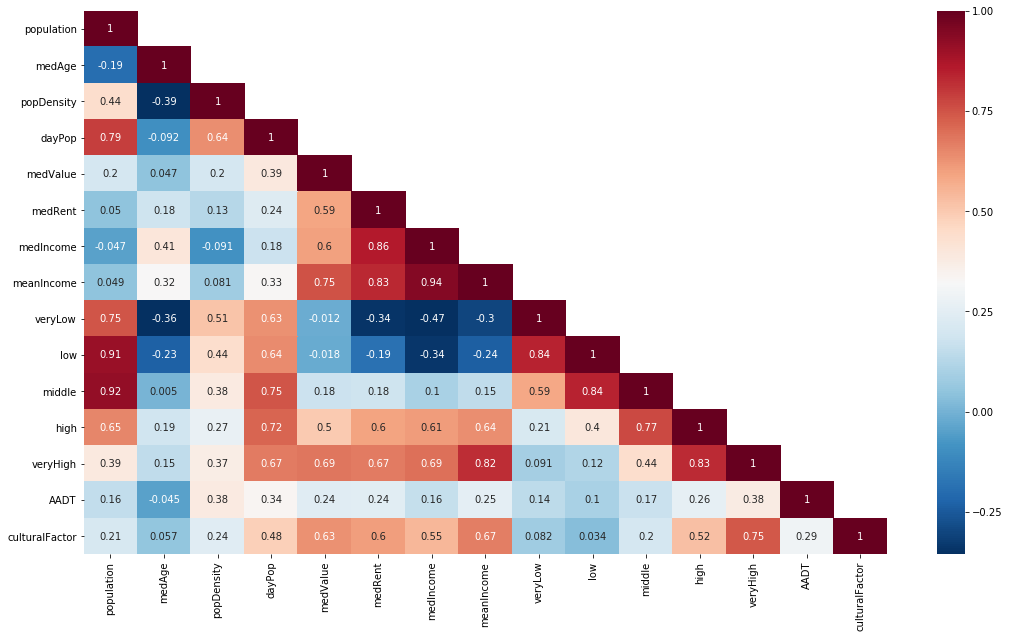

In [19]:
# heatMap(co,'Correlation of Features with Each Other',(18,12))
corr(features)

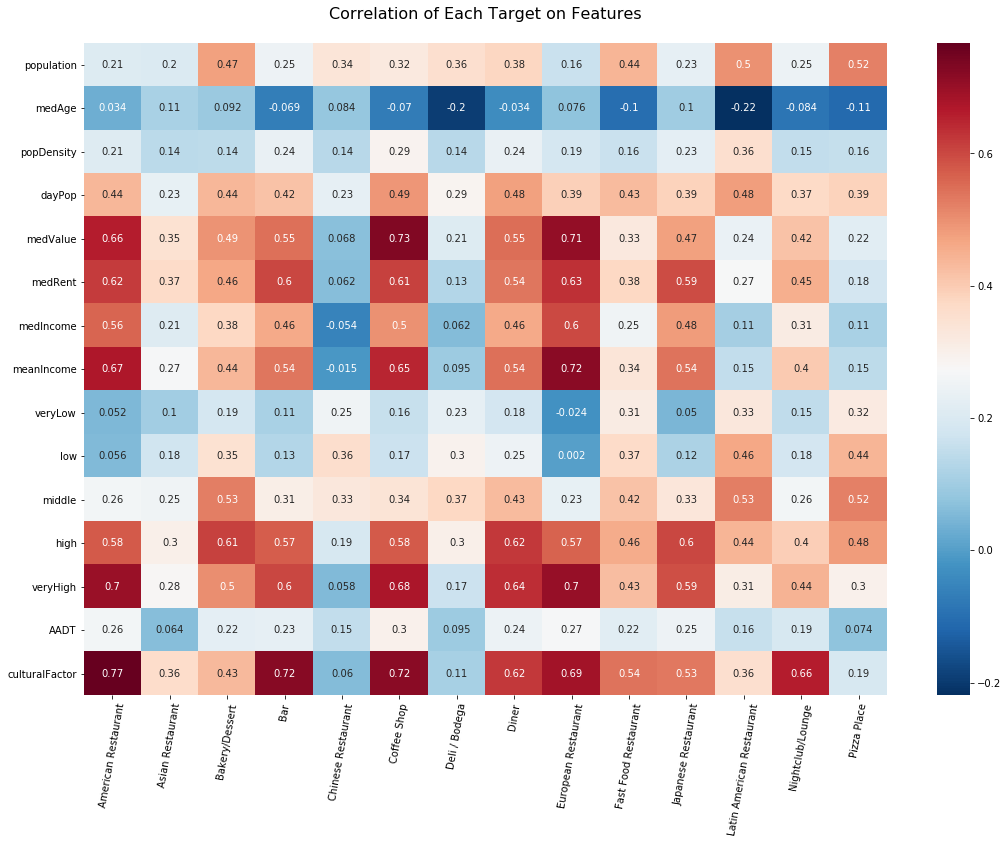

In [20]:
corrs={}
for i,col in targets.iteritems():
    corr=features.corrwith(col)
    corrs.update({col.name:corr})
corrs=DataFrame(corrs)
heatMap(corrs,'Correlation of Each Target on Features',(18,12))

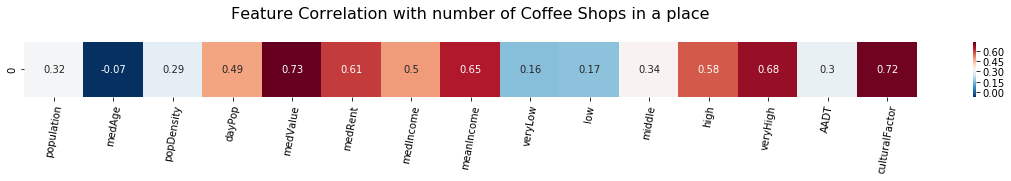

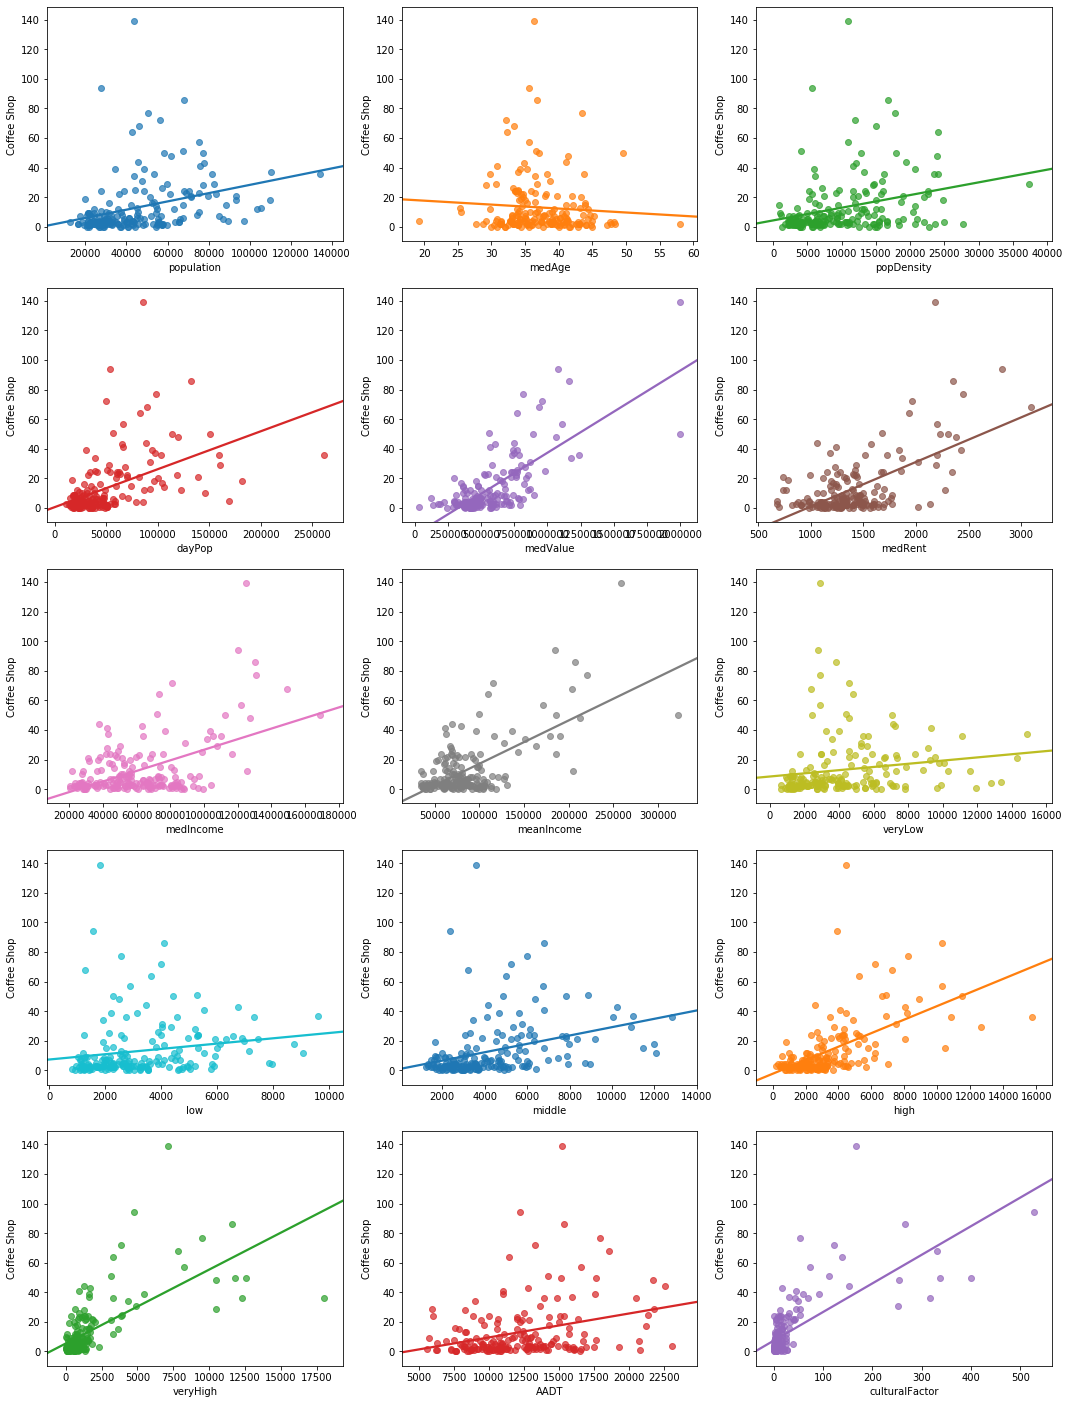

In [21]:
plotFeatures(features,getTarget(5))

#### Histogram Distribution of Features
It is seen that most of the histograms are right skewed

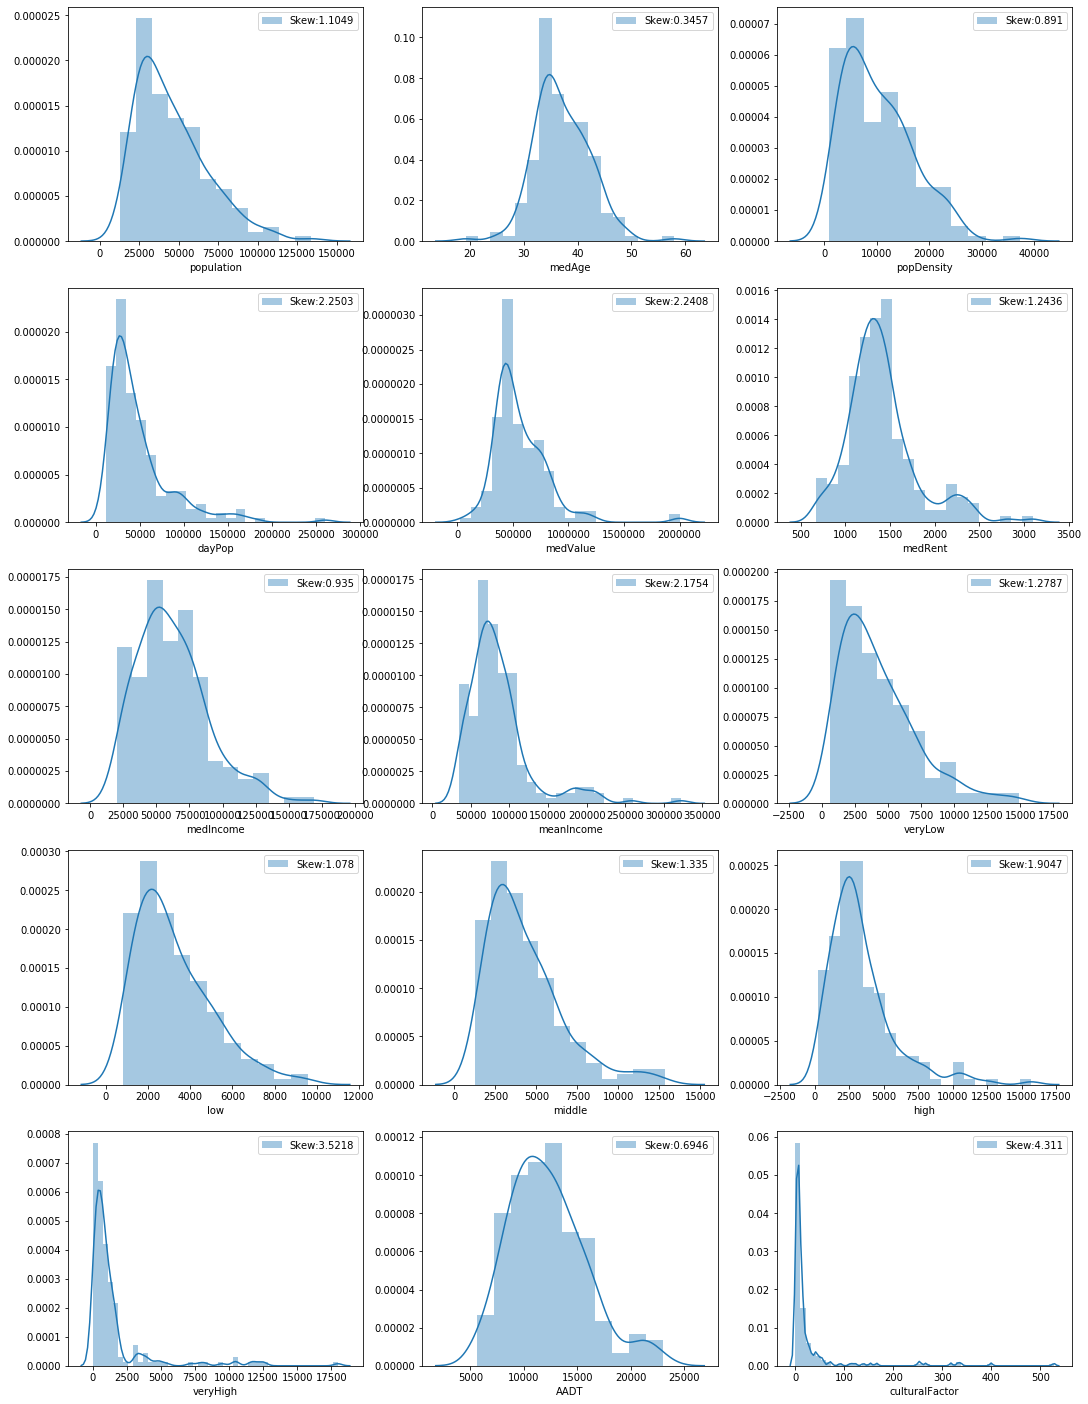

In [22]:
univariatePlots(features)

## Machine Learning

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import ElasticNet,LinearRegression
from sklearn.metrics import mean_squared_error,mean_squared_log_error,r2_score,make_scorer
from sklearn.preprocessing import PolynomialFeatures,RobustScaler,StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV,KFold,train_test_split,RandomizedSearchCV
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.svm import SVR
from xgboost import XGBRegressor

#### Metrics and Transformation Functions

In [62]:
def inverseLog(series,series1="None"):
    if type(series1)!=str:
        return np.expm1(series),np.expm1(series1)
    return np.expm1(series)

from sklearn.metrics.regression import check_consistent_length

def RMSE(yTrue,yPred):
    check_consistent_length(yTrue, yPred)  
    return np.sqrt(np.mean((np.expm1(yTrue)-np.expm1(yPred))**2))

RmseScorer=make_scorer(RMSE,greater_is_better=False)

def r2(yTrue,yPred):
    check_consistent_length(yTrue, yPred)
    return r2_score(inverseLog(yTrue),inverseLog(yPred))

R2Scorer=make_scorer(r2,greater_is_better=True)

def resultMetrics(yTrue,yPred):
    yTrue,yPred=inverseLog(yTrue,yPred)
    return r2_score(yTrue,yPred),np.sqrt(mean_squared_error(yTrue,yPred)),np.std(yTrue-yPred)

### Preprocessing

Preprocessing includes the following processes:
<ul>
<li>Logarithmic transformation on both the features and the targets and it reduces the skew and makes the distribution similiar to a normal distibution which is best for Linear Regression models. 
<li>Removing Outliers with Z-score more than 3 if any.
<li>Handle the problem of multicollinearity by aggregating components with correlation more than 0.9 into one using PCA
</ul>
Finally the processed data is split into training and testing data in the ratio 3:1 for Machine Learning

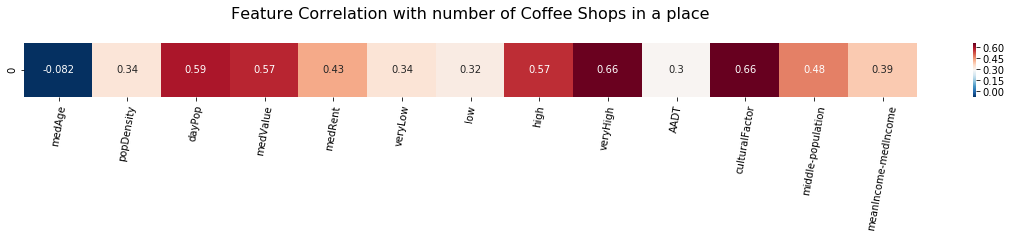

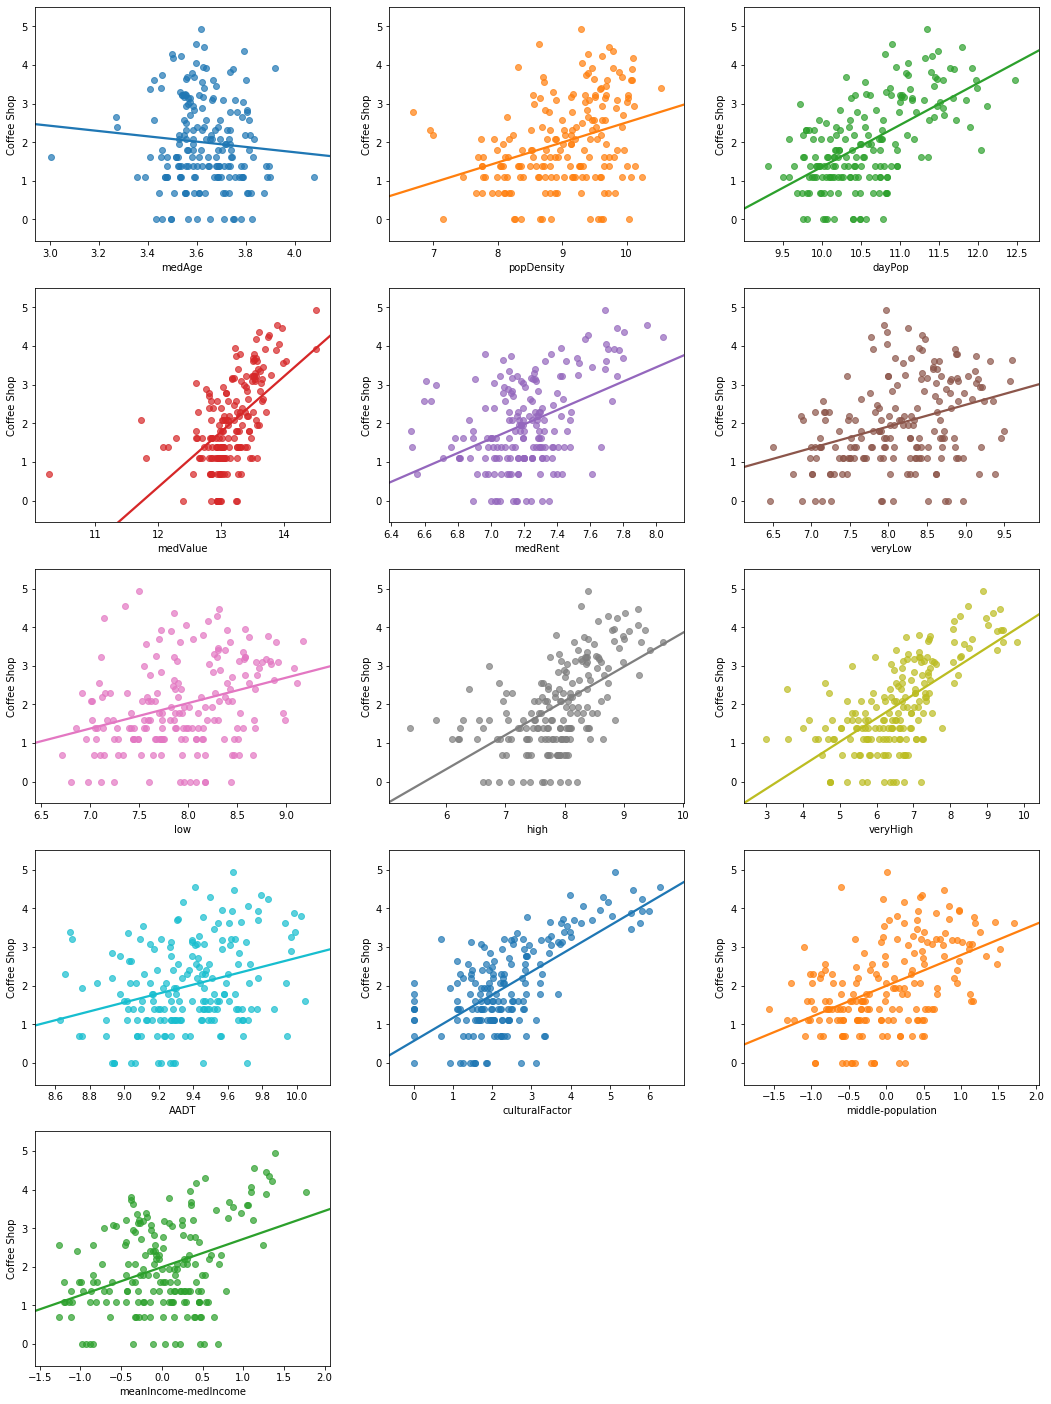

In [25]:
X=features.copy()
currentTarget=5
y=getTarget(currentTarget)

X,y=logTransform(X,y)
X,y=removeOutliers(X,y)
X=handleMulticollinearity(X,0.9)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=33)

plotFeatures(X,y)

### Basic Regressors and Cross-validated Hyper-parameter Tuning

The optimizer performs Cross Validation on the passed Estimator and updates its results to a dataframe for visualization

In [26]:
def Optimizer(estimator,name,params,X=x_train,y=y_train,cv=10,method='Grid'):
    if ((name not in optEstimators.keys()or params!=parameters[name]) and method=='Grid') or \
    (method=='Random' and (name not in parameters.keys() or name not in estimators.keys() or params!=parameters[name])):
        kf=KFold(cv,shuffle=True,random_state=34)
        parameters.update({name:params})
        if(method=='Random' and len(params.keys())>=5):
            opt=RandomizedSearchCV(estimator,param_distributions=parameters[name],n_iter=1000,cv=kf,iid=False,scoring=RmseScorer,random_state=0,return_train_score=True,n_jobs=-1)             
        elif method=='Random':
            opt=RandomizedSearchCV(estimator,param_distributions=parameters[name],n_iter=500,cv=kf,iid=False,scoring=RmseScorer,random_state=0,return_train_score=True,n_jobs=-1)
        else:
            opt=GridSearchCV(estimator,param_grid=parameters[name],cv=kf,iid=False,scoring=RmseScorer,n_jobs=-1,return_train_score=True)
        opt.fit(X,y)
        tmp=DataFrame(opt.cv_results_)
        tmp.drop(tmp.columns[:4],axis=1,inplace=True)
        keep=[('std' in i)or('mean' in i)or('param_' in i) for i in tmp.columns]
        tmp=tmp.loc[:,keep]
        tmp[['mean_test_score','mean_train_score']]=tmp[['mean_test_score','mean_train_score']].abs()
        if method=='Random':
            results.update({name:tmp})
            estimators.update({name:opt})
        else:
            optResults.update({name:tmp})
            optEstimators.update({name:opt})
    else:
        if method=='Random':
            opt=estimators[name]
        else:
            opt=optEstimators[name]
    print(name.upper())
    print("Best Parameters:{}\nBest Score:{}".format(opt.best_params_,opt.best_score_))
    return opt.best_estimator_

### Pipeline Creation

Numerous pipelines including a polynomial transform and Scaling followed by numerous estimators. All the models of the estimators are taken and they are fine tuned and used to make a comined prediction. The individual estimators are bagged to make an ensemble.

Note: Linear Regressor and Decision Tree were considered in the Initial Model but were dropped due to poor results



In [27]:
# linear=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',LinearRegression())])
elastic=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',ElasticNet())])
svr=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',SVR())])
# decisionTree=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',DecisionTreeRegressor())])
# randomForest=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',RandomForestRegressor(random_state=84))])
gradientBoosting=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',GradientBoostingRegressor(random_state=316))])
xgb=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',XGBRegressor(objective='reg:squarederror'))])

In [28]:
degrees=[1,2]
zeroToOne=list(np.arange(0,1.1,0.1))
pointToOne=list(np.arange(0.1,1.1,0.1))
depths=list(np.arange(3,10,1))

### Randomized Search Parameter Tuning
The range of the optimum hyper-Parameters is found in this section for all estimators

#### ElasticNet Regressor

ELASTICNET
Best Parameters:{'reg__l1_ratio': 0.0, 'reg__alpha': 0.0001, 'poly__degree': 2}
Best Score:-11.908787204048497

Test Set:
R2 Score:0.6062506665117591, Root Mean Square Error:12.63077164961651, Standard Deviation of Error:12.608059200167572


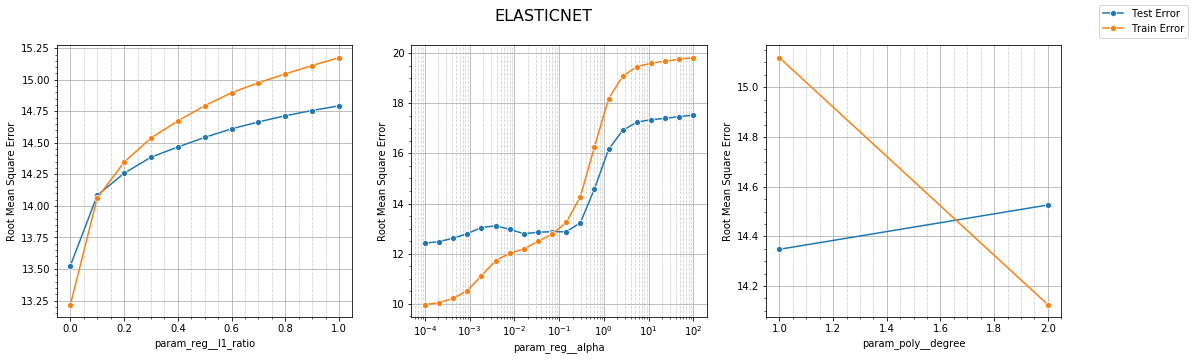

In [29]:
%%capture --no-stdout --no-display

alphas=list(np.logspace(-4,2,20))

params={
        'poly__degree':degrees,
        'reg__alpha':alphas,
        'reg__l1_ratio':zeroToOne,
       }

Elastic=Optimizer(elastic,'elasticNet',params,x_train,y_train,method="Random",cv=10)
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,Elastic.predict(x_test))))
visualizeCV('elasticNet',grouping='',which=results)

#### Support Vector Regressor

SVR
Best Parameters:{'reg__gamma': 0.03359818286283781, 'reg__epsilon': 0.14384498882876628, 'reg__C': 1.0, 'poly__degree': 1}
Best Score:-8.627796773519936

Test Set:
R2 Score:0.723783765955238, Root Mean Square Error:10.578998795908479, Standard Deviation of Error:10.39164997443617


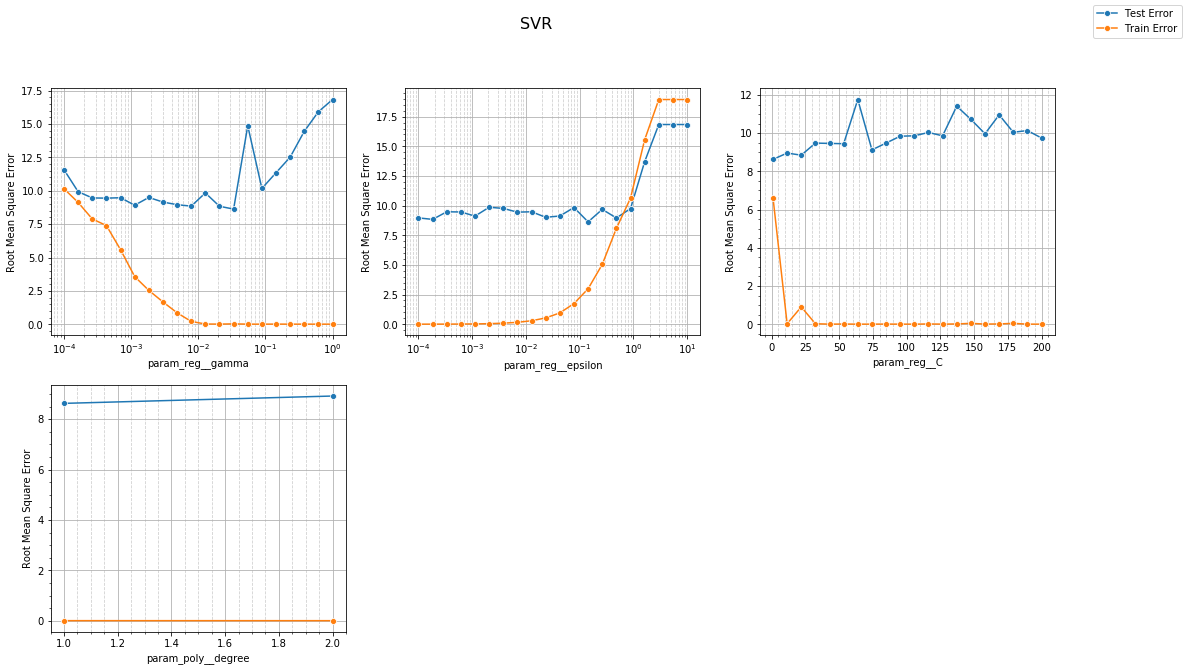

In [32]:
params={
        'poly__degree':degrees,
        'reg__gamma':list(np.logspace(-4,0,20)), 
        'reg__C':list(np.linspace(1,200,20)),
        'reg__epsilon':list(np.logspace(-4,1,20)),
       }

Svr=Optimizer(svr,'svr',params,x_train,y_train,cv=10,method="Random")
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,Svr.predict(x_test))))
visualizeCV('svr',grouping='min',which=results)

#### Random Forest Regressor is ignored due to poor accuracy of predictions with the current dataset

#### Gradient Boosing Regressor

GRADIENTBOOSTING
Best Parameters:{'reg__min_samples_split': 2, 'reg__min_samples_leaf': 15, 'reg__max_features': 'auto', 'reg__max_depth': 8, 'reg__learning_rate': 0.01, 'poly__degree': 1}
Best Score:-3.194559040891376

Test Set:
R2 Score:0.18249534690591995, Root Mean Square Error:3.6236820920487984, Standard Deviation of Error:3.4657141799700284


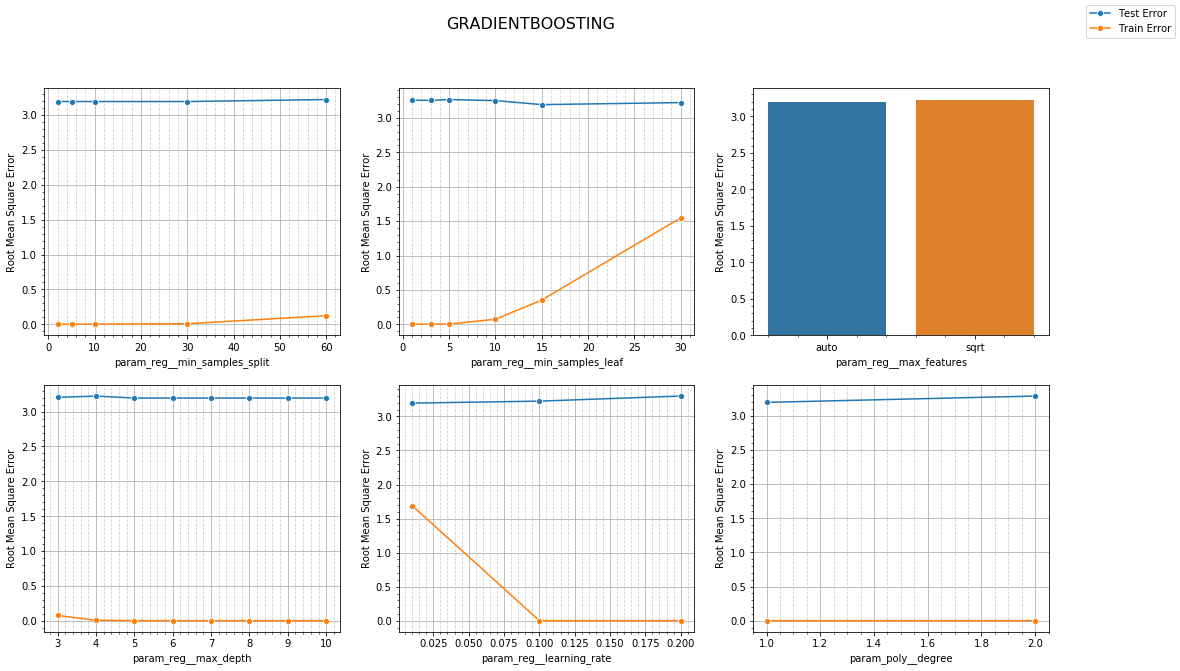

In [859]:
params={
        'poly__degree':degrees,
        'reg__max_depth':list(np.arange(3,11,1)),
        'reg__min_samples_leaf':[1,3,5,10,15,30],
        'reg__min_samples_split':[2,5,10,30,60],
        'reg__max_features':['auto','sqrt'],
        'reg__learning_rate':[0.01,0.1,.2],
       }

GradientBoosting=Optimizer(gradientBoosting,'gradientBoosting',params,x_train,y_train,method="Random")
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,GradientBoosting.predict(x_test))))
visualizeCV('gradientBoosting',grouping='min',which=results)

#### XGB Regressor

XGB
Best Parameters:{'reg__subsample': 1.0, 'reg__min_child_weight': 5, 'reg__max_depth': 6, 'reg__learning_rate': 0.1, 'reg__gamma': 0.2, 'poly__degree': 1}
Best Score:-6.094469740871134

Test Set:
R2 Score:0.3198465089886142, Root Mean Square Error:7.678139113498965, Standard Deviation of Error:7.473092007359481


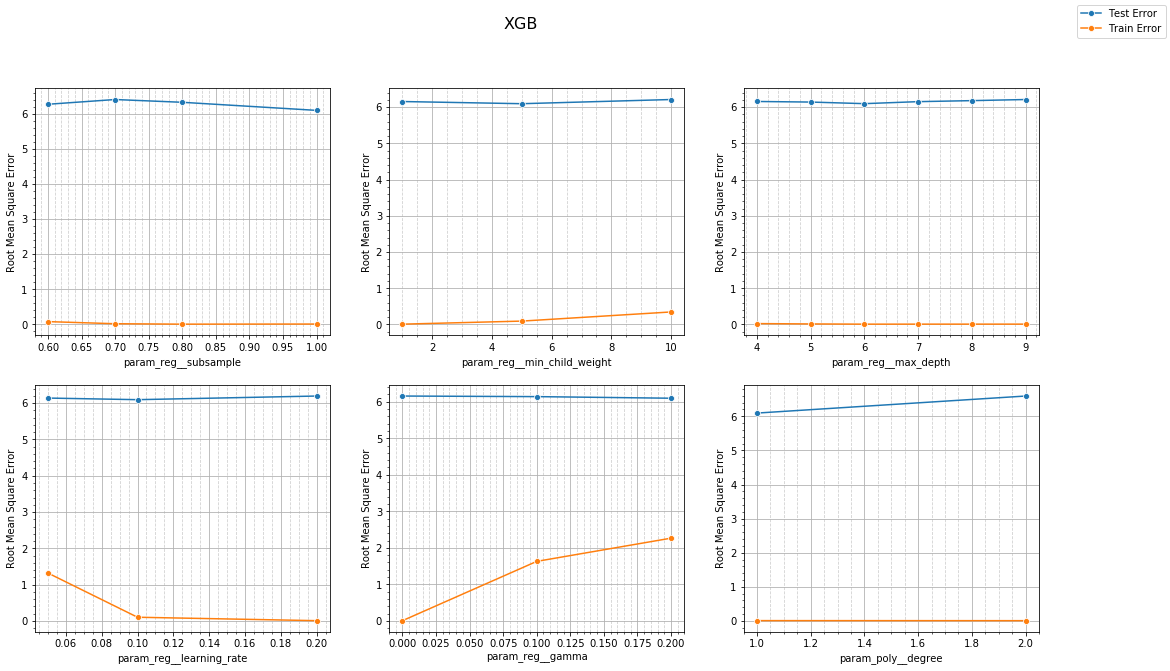

In [260]:
params={
        'poly__degree':degrees,
        'reg__max_depth':list(np.arange(4,10,1)),
        'reg__learning_rate':[0.05,0.1,0.2],
        'reg__gamma':[0,0.1,0.2],
        'reg__min_child_weight':[1,5,10],
        'reg__subsample':[0.6,0.7,0.8,1.0]
       }

XGB=Optimizer(xgb,'xgb',params,x_train,y_train,cv=10,method="Random")
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,XGB.predict(x_test))))
visualizeCV('xgb',grouping='min',which=results)

##  Hyperparameter Fine-Tuning

The Random Search cross Validation Results provide a neighborhood to search for the best parameters for the estimators. The best estimator may not necessarily be the best estimator because it takes only the testing score and there could be a better estimator predicted from the output graphs manually and optimized. A combination of the best parameters of the Random Search and manual optimization is used to find the best parameters.

We also drop the regressors with low accuracy for further optimization.

The grid search is done iteratively manually for models with long runtimes.

**After the grid search, some manual tweaking is done to find the best regressor.**

#### ElasticNet Regressor

ELASTICNET
Best Parameters:{'poly__degree': 1, 'reg__alpha': 0.024244620170823284, 'reg__l1_ratio': 0.5}
Best Score:-3.1156478919084316
Train Set:
R2 Score:0.3836776464695395, Root Mean Square Error:3.016967314256008, Standard Deviation of Error:2.9543293578643235

Test Set:
R2 Score:0.1805896903123556, Root Mean Square Error:3.6279031530790373, Standard Deviation of Error:3.4659722123401657

BEST ESTIMATOR:
Train Set:
R2 Score:0.5267417168706066, Root Mean Square Error:2.6437218305194334, Standard Deviation of Error:2.603096349166192

Test Set:
R2 Score:0.13029157318925177, Root Mean Square Error:3.7375913168532082, Standard Deviation of Error:3.5352979996069545


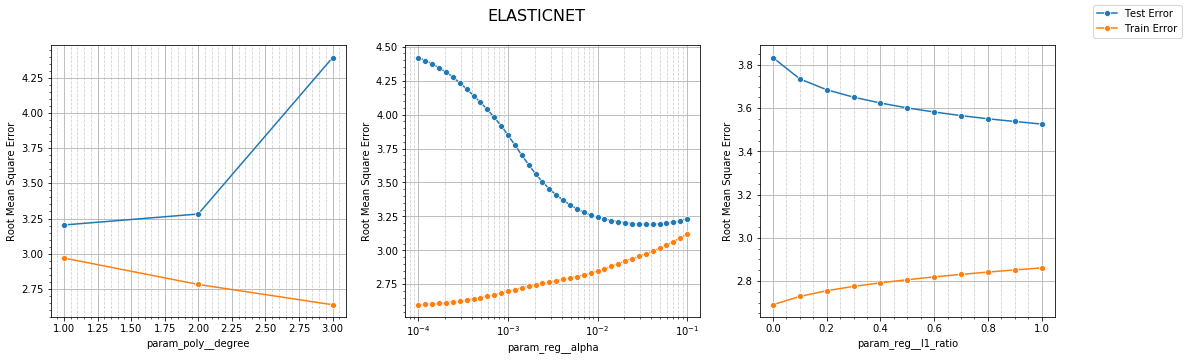

In [89]:
%%capture --no-stdout --no-display

params={
        'poly__degree':[1,2,3],
        'reg__alpha':list(np.logspace(-4,-1,40)),
        'reg__l1_ratio':zeroToOne,
       }

optElastic=Optimizer(elastic,'elasticNet',params,x_train,y_train,cv=10)
print("Train Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_train,optElastic.predict(x_train))))
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,optElastic.predict(x_test))))
visualizeCV('elasticNet',grouping='',which=optResults)

params={
        'poly__degree':2,
        'reg__alpha':0.0005,
        'reg__l1_ratio':0,
       }

bestElastic=elastic.set_params(**params)
bestElastic.fit(x_train,y_train)
print("\nBEST ESTIMATOR:")
print("Train Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_train,bestElastic.predict(x_train))))
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,bestElastic.predict(x_test))))

#### Support Vector Regressor

SVR
Best Parameters:{'poly__degree': 2, 'reg__C': 1.4384498882876628, 'reg__epsilon': 0.08858667904100823, 'reg__gamma': 0.001}
Best Score:-3.0607325416437794

Train Set:
R2 Score:0.4366712370105862, Root Mean Square Error:2.8843476756382374, Standard Deviation of Error:2.87650917404116

Test Set:
R2 Score:0.20439023143515822, Root Mean Square Error:3.5748269759960407, Standard Deviation of Error:3.504393254811044

BEST ESTIMATOR:
Train Set:
R2 Score:0.418567393854428, Root Mean Square Error:2.9303286872221084, Standard Deviation of Error:2.833672542259305

Test Set:
R2 Score:0.16170765140449161, Root Mean Square Error:3.6694647848444704, Standard Deviation of Error:3.447286592935892


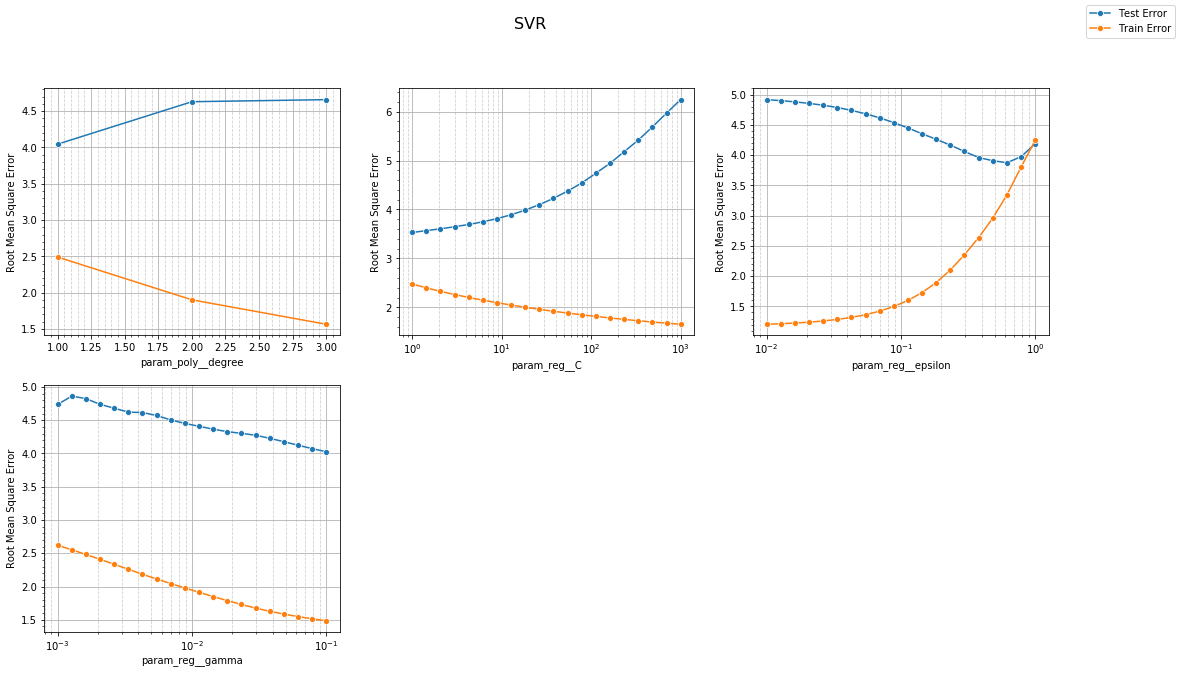

In [85]:
params={
        'poly__degree':[1,2,3],
        'reg__gamma':list(np.logspace(-3,-1,20)), 
        'reg__C':list(np.logspace(0,3,20)),
        'reg__epsilon':list(np.logspace(-2,0,20)),
       }

optSvr=Optimizer(svr,'svr',params,x_train,y_train,cv=10)
print("\nTrain Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_train,optSvr.predict(x_train))))
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,optSvr.predict(x_test))))
visualizeCV('svr',grouping='',which=optResults)

params={
        'poly__degree':1,
        'reg__gamma':0.01,
        'reg__C':36,
        'reg__epsilon':0.51
       }

bestSVR=svr.set_params(**params)
bestSVR.fit(x_train,y_train)
print("\nBEST ESTIMATOR:")
print("Train Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_train,bestSVR.predict(x_train))))
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,bestSVR.predict(x_test))))

#### Random Forest Regressor is ignored due to poor accuracy of predictions with the current dataset

#### Gradient Boosing Regressor

GRADIENTBOOSTING
Best Parameters:{'poly__degree': 2, 'reg__max_depth': 4, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 41, 'reg__min_samples_split': 2}
Best Score:-3.1803163813968185

Train Set:
R2 Score:0.5572078614060827, Root Mean Square Error:2.5572111899253898, Standard Deviation of Error:2.497930056852203

Test Set:
R2 Score:0.14976248072845288, Root Mean Square Error:3.6955161614997865, Standard Deviation of Error:3.5256789090883593

Train Set:
R2 Score:0.5249396650537426, Root Mean Square Error:2.6487503713363383, Standard Deviation of Error:2.5714578119282745

Test Set:
R2 Score:0.22227087923213162, Root Mean Square Error:3.534428117195626, Standard Deviation of Error:3.3866743180502694


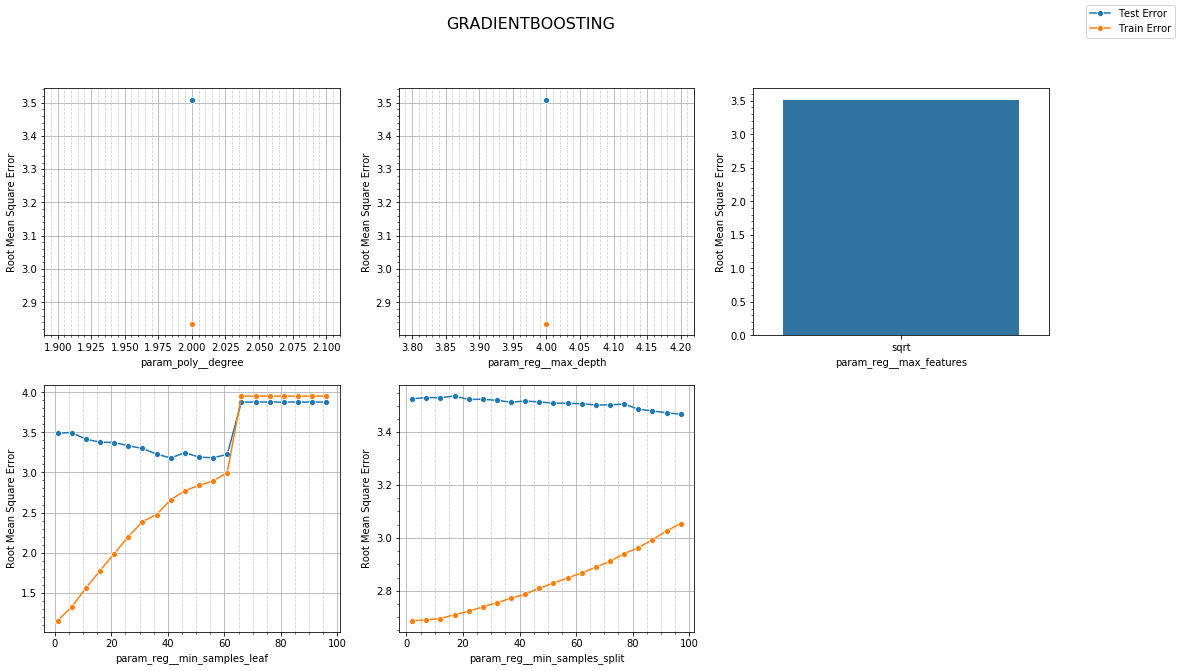

In [1078]:
params={
        'poly__degree':[2],
#         'reg__max_depth':list(np.arange(3,10,1)),
        'reg__max_depth':[4],
        'reg__max_features':['sqrt'],
#         'reg__min_samples_leaf':[1],
        'reg__min_samples_leaf':list(np.arange(1,101,20)),
        'reg__min_samples_split':list(np.arange(2,102,20)),
#         'reg__min_samples_split':[2],
#         'reg__n_estimators':[100,200,400,800],
#         'reg__learning_rate':[0.01,.2,.3]+list(np.arange(0.05,1.1,0.01)),
       }

optGB=Optimizer(gradientBoosting,'gradientBoosting',params,x_train,y_train,cv=10)
print("\nTrain Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_train,optGB.predict(x_train))))
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,optGB.predict(x_test))))
visualizeCV('gradientBoosting',grouping='',which=optResults)

params={
        'poly__degree':2,
        'reg__max_depth':4,
        'reg__min_samples_leaf':1,
        'reg__n_estimators':1000,
        'reg__max_features':'sqrt',
        'reg__min_samples_split':80,
        'reg__learning_rate':0.0025,
       }

bestGB=gradientBoosting.set_params(**params)
bestGB.fit(x_train,y_train)
print("\nTrain Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_train,bestGB.predict(x_train))))
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,bestGB.predict(x_test))))

#### XGB Regressor

XGB
Best Parameters:{'poly__degree': 2, 'reg__gamma': 0.19, 'reg__learning_rate': 0.01, 'reg__max_depth': 4, 'reg__min_child_weight': 1, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.8, 'reg__reg_lambda': 0, 'reg__subsample': 1}
Best Score:-3.404585217267699

Train Set:
R2 Score:0.696464862870934, Root Mean Square Error:2.117245075193345, Standard Deviation of Error:2.047978546360646

Test Set:
R2 Score:0.2430383910498659, Root Mean Square Error:3.4869193295341927, Standard Deviation of Error:3.3351010163257513


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Train Set:
R2 Score:0.7322876509755177, Root Mean Square Error:1.988386691437246, Standard Deviation of Error:1.9236591377010974

Test Set:
R2 Score:0.26943412719825854, Root Mean Square Error:3.42558433225406, Standard Deviation of Error:3.278855561099707


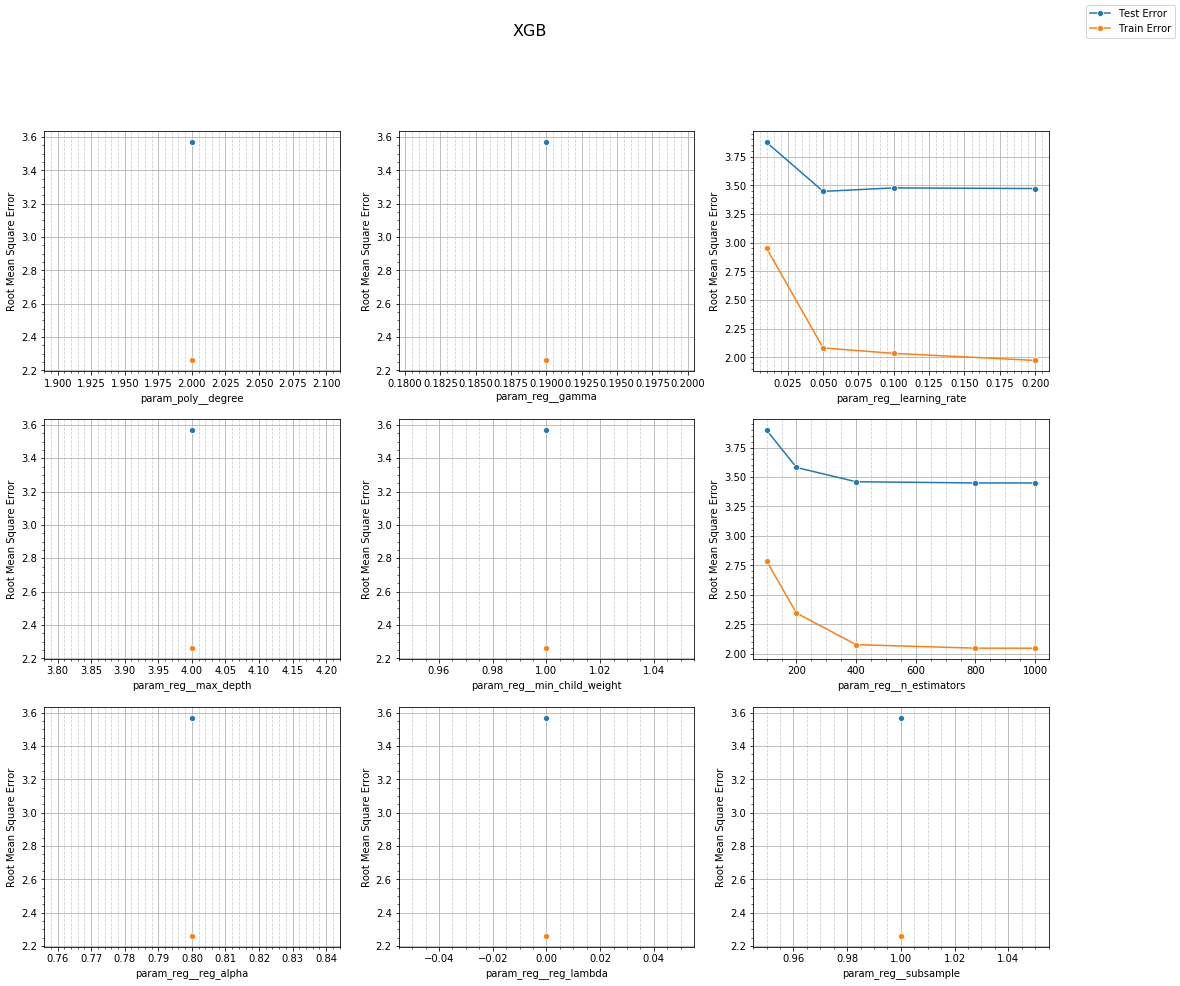

In [1187]:
params={
        'poly__degree':[2],
#         'reg__max_depth':list(np.arange(3,10,1)),
        'reg__max_depth':[4],
        'reg__n_estimators':[100,200,400,800,1000],
        'reg__learning_rate':[0.01,0.05,0.1,.2],
#         'reg__min_child_weight':list(np.arange(1,101,5)),
        'reg__min_child_weight':[1],
#         'reg__subsample':[0.5,0.6,0.8,1.0],
#         'reg__gamma':[0,0.1,0.2,0.3],
        'reg__subsample':[1],
        'reg__gamma':[0.19],
        'reg__reg_lambda':[0],
        'reg__reg_alpha':[0.8],
#         'reg__reg_lambda':[0,0.2,0.4,0.6,0.8,1],
#         'reg__reg_alpha':[0,0.2,0.4,0.6,0.8,1],
       }

optXGB=Optimizer(xgb,'xgb',params,x_train,y_train,cv=10)
print("\nTrain Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_train,optXGB.predict(x_train))))
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,optXGB.predict(x_test))))
visualizeCV('xgb',grouping='',which=optResults)

params={
        'poly__degree':2,
        'reg__max_depth':4,
        'reg__n_estimators':500,
        'reg__learning_rate':0.1,
        'reg__min_child_weight':1,
        'reg__subsample':1,
        'reg__gamma':0.19,
        'reg__reg_lambda':0.,
        'reg__reg_alpha':0.8,
       }

bestXGB=xgb.set_params(**params)
bestXGB.fit(x_train,y_train)
print("\nTrain Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_train,bestXGB.predict(x_train))))
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,bestXGB.predict(x_test))))

### Ensemble Predictor Model
Existing individual predictors are loaded from a persisted file

In [63]:
from joblib import dump, load

def EnsemblePredict(model,x):
    estimators=model[0]
    ratios=model[1]
    predictions=list(zip(*[predictor.predict(x)*mult for mult,predictor in zip(ratios,list(estimators.values()))]))
    predictions=[sum(value) for value in predictions]
    return predictions

Predictors=load('Predictors.joblib')
Predictors.keys()

dict_keys(['American Restaurant', 'Asian Restaurant', 'Bakery/Dessert', 'Bar', 'Chinese Restaurant', 'Coffee Shop', 'Deli / Bodega', 'Diner', 'European Restaurant', 'Fast Food Restaurant', 'Japanese Restaurant', 'Latin American Restaurant', 'Nightclub/Lounge', 'Pizza Place'])

In [1217]:
bestEstimators=[
    {'ElasticNet':bestElastic,
    'SVR':bestSVR,
    'GradientBoosting':bestGB,
    'XGB':bestXGB},
    [0.,0.,0.1,0.95]
]

Predictors.update({getTarget(currentTarget).name:bestEstimators})

print("\nTrain Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_train,EnsemblePredict(Predictors[getTarget(currentTarget).name],x_train))))
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,EnsemblePredict(Predictors[getTarget(currentTarget).name],x_test))))


Train Set:
R2 Score:0.7679104353097947, Root Mean Square Error:1.851375244395121, Standard Deviation of Error:1.8256875061349658

Test Set:
R2 Score:0.3147060954629787, Root Mean Square Error:3.317748088071176, Standard Deviation of Error:3.3105683424569947


If the results are satisfactory, the current regressor is persisted

In [130]:
# Commented out to avoid accidental over Write

# dump(Predictors,'Predictors.joblib')

## Results

In [1261]:
X=features.copy()
currentTarget=0
y=getTarget(currentTarget)

X,y=logTransform(X,y)
X,y=removeOutliers(X,y)
X=handleMulticollinearity(X,0.9)

Removing 0 rows as Outliers:
 []


In [64]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_predict,cross_validate,cross_val_score

train=[]
test=[]

for i,col in targets.iteritems():   
    y=col
    X=features.copy()
    X,y=logTransform(X,y)
    X,y=removeOutliers(X,y)
    X=handleMulticollinearity(X,0.9)
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=33)
    tmp={}
    tmp1={}
    for m in Predictors[col.name][0]:
        n=Predictors[col.name][0][m]
        tmp.update({m:r2(y_test,n.predict(x_test))})
        tmp1.update({m:r2(y_train,n.predict(x_train))})
    tmp.update({'Ensemble':r2(y_test,EnsemblePredict(Predictors[col.name],x_test))})
    tmp1.update({'Ensemble':r2(y_train,EnsemblePredict(Predictors[col.name],x_train))})
    test.append(tmp)
    train.append(tmp1)
train=DataFrame(train,index=targets.columns)
test=DataFrame(test,index=targets.columns)

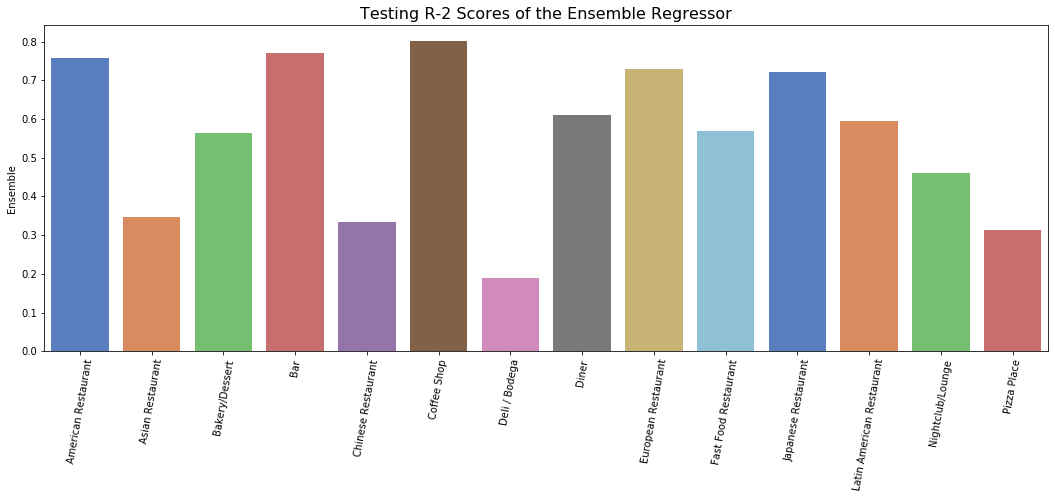

In [65]:
plt.figure(figsize=(18,6))
# ax= sns.barplot(train.index,'Ensemble',data=train,palette='muted')
ax=sns.barplot(test.index,'Ensemble',data=test,palette='muted')
ax.set_xticklabels(train.index,rotation=80)
ax.set_title("Testing R-2 Scores of the Ensemble Regressor",fontsize=16)
plt.show()

In [66]:
X=features.copy()
X=logTransform(X)
X=handleMulticollinearity(X,0.9)

predictions={}
    
for i in targets.columns:
    predictions.update({"pred_"+i:inverseLog(EnsemblePredict(Predictors[i],X))})

In [67]:
tmpdf=df.iloc[:,:6]
tmpdf=tmpdf.join(features).join(targets)

In [74]:
resultDf=tmpdf.join(DataFrame(predictions))
for i in targets.columns:
    resultDf["scope_"+i]=resultDf["pred_"+i]-resultDf[i]
preds=resultDf.iloc[:,-28:-14]

#### Persist the results as JSON

In [75]:
# resultDf.to_json('Visualization.json',orient='table')

## Actual vs Predicted Results - Visualizations

### Histogram Plots

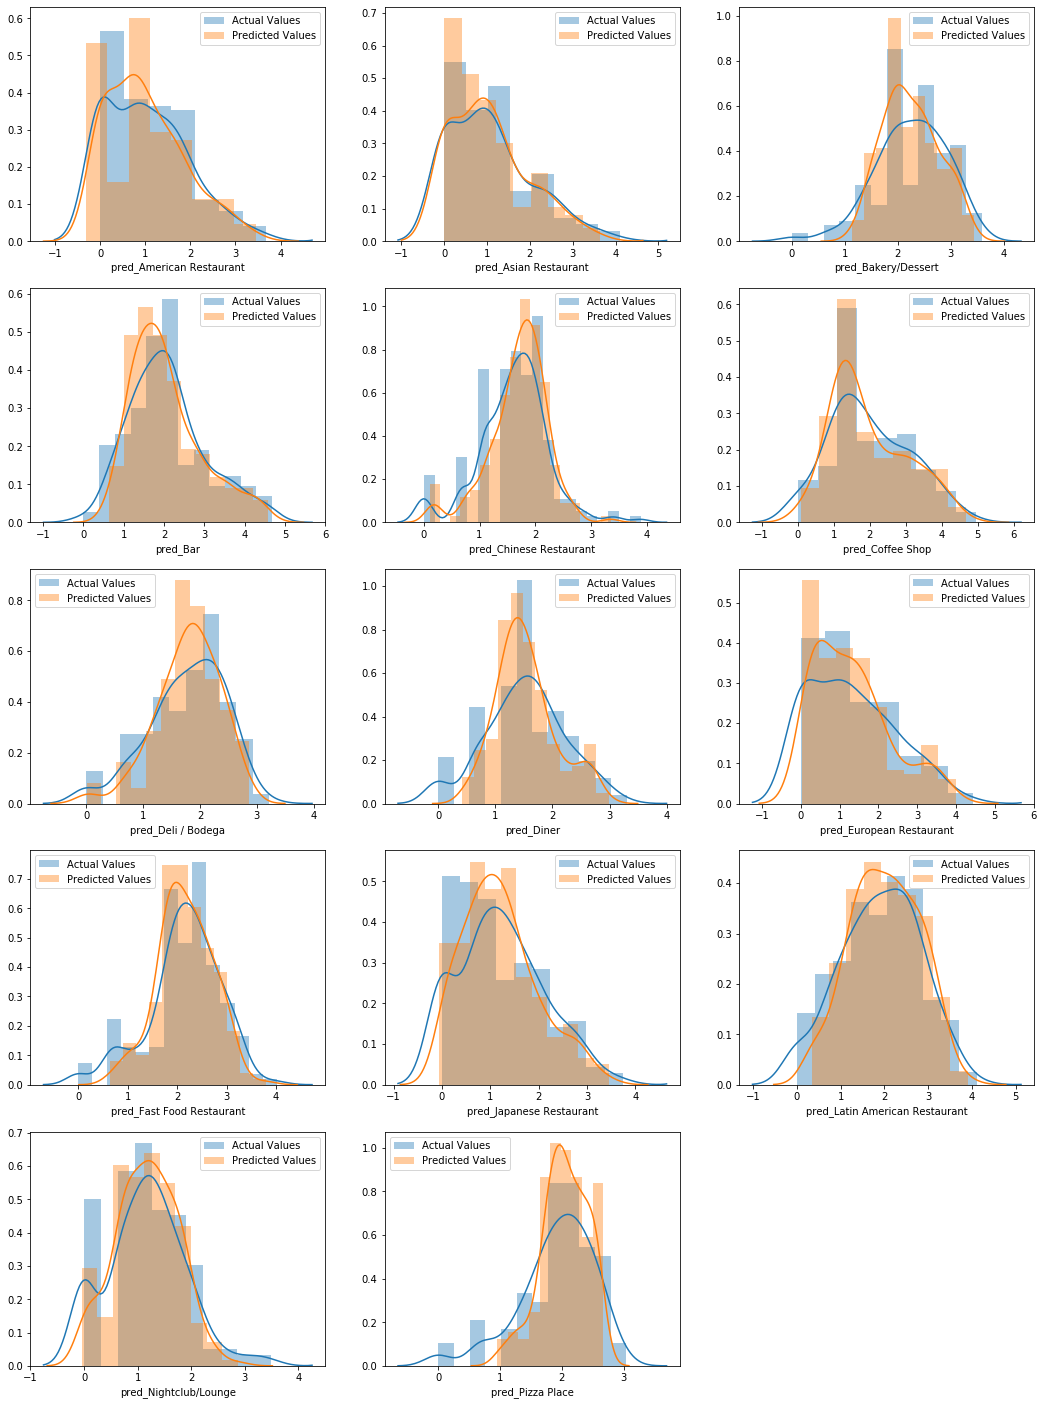

In [78]:
univariatePlots(f=logTransform(targets),f1=logTransform(preds))

### Scatter Plots - Best Result

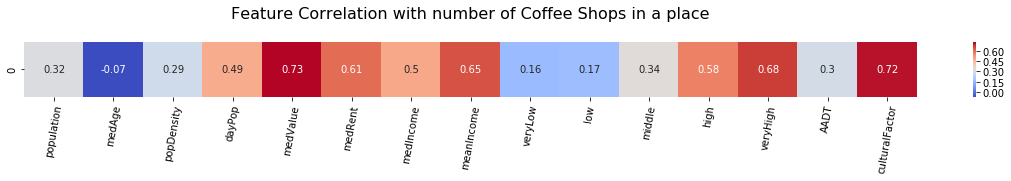

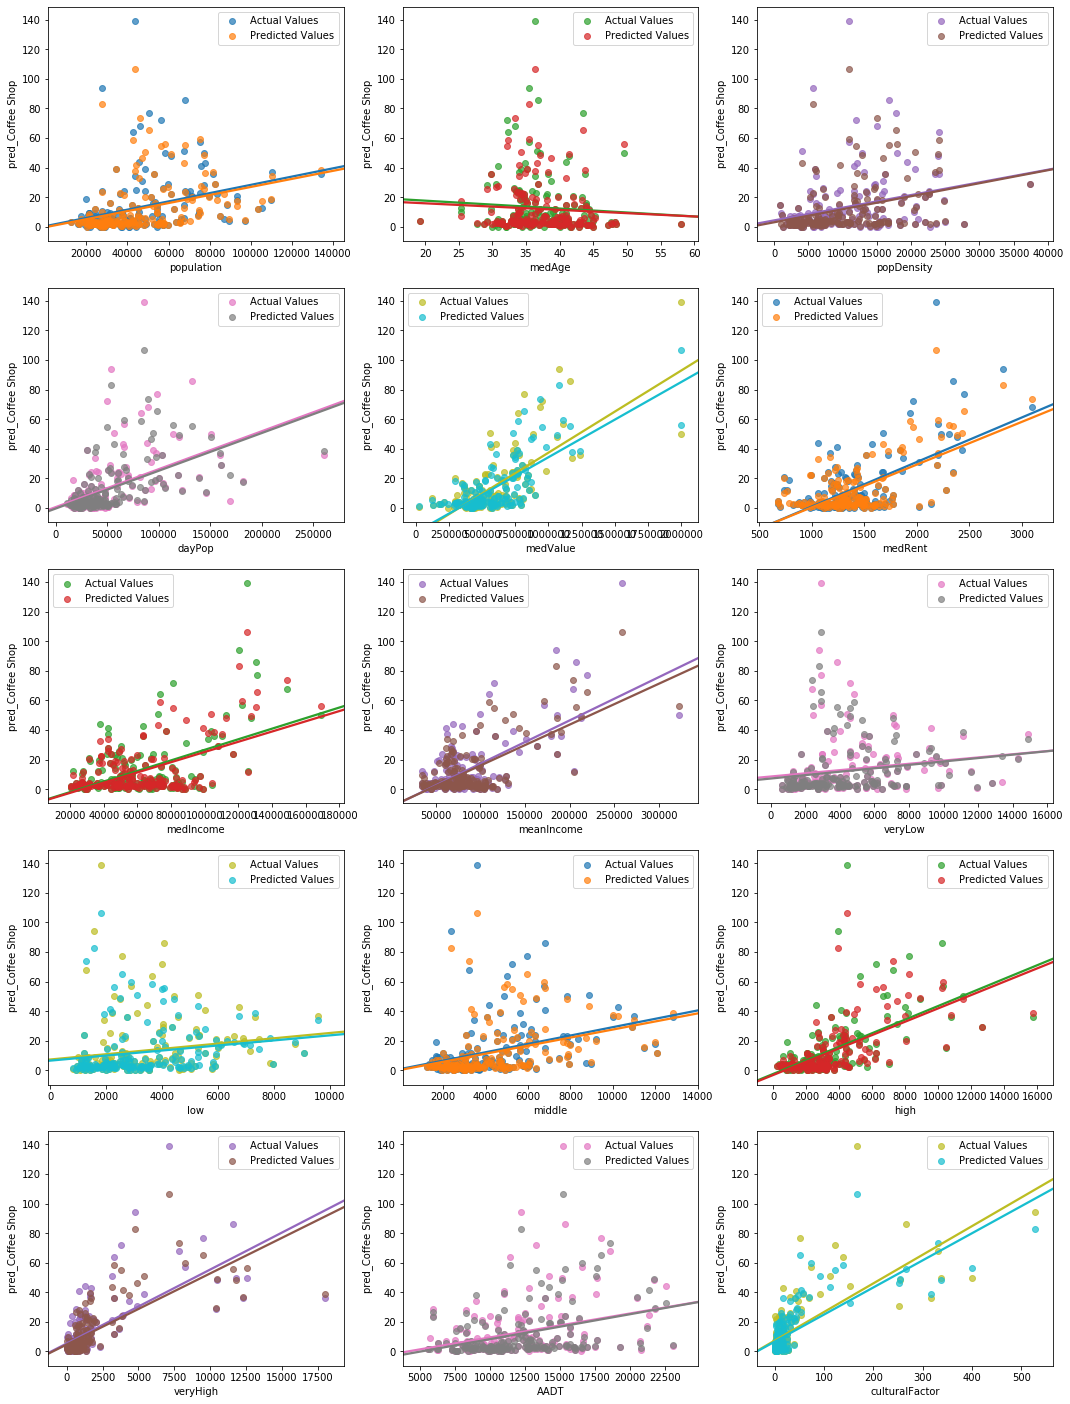

In [120]:
current=5
plotFeatures(features,getTarget(current),t1=preds.iloc[:,current])

### Scatter Plots -  Worst Result

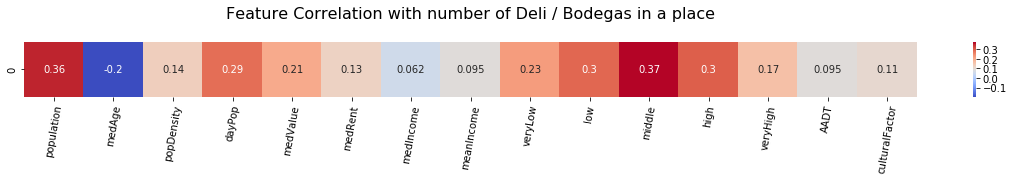

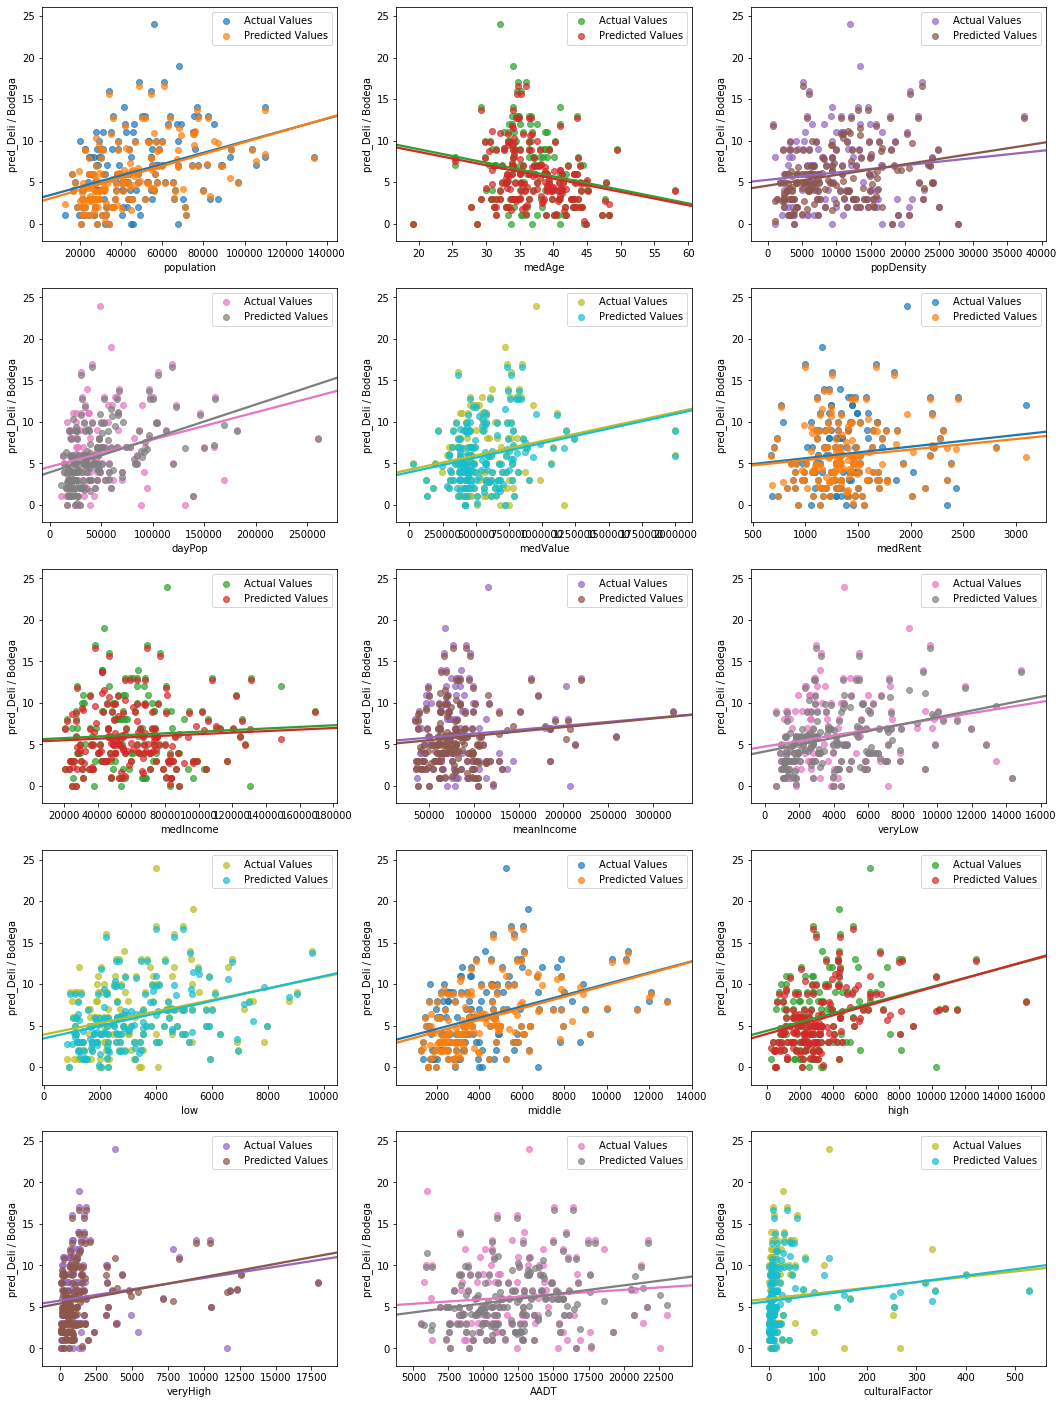

In [122]:
current=6
plotFeatures(features,getTarget(current),t1=preds.iloc[:,current])

The rest of the Geo Spatial Visualizations are continued in the [Next File](https://github.com/gokulmuthiah/Coursera_Capstone/blob/master/5.Visualization.ipynb).